# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### 🔥 PyTorch: fine tuning

### Подготовка к работе

1. Загрузи этот ноутбук на Google Colab
2. Подгрузи архив [датасета](https://www.kaggle.com/datasets/ikobzev/architectural-heritage-elements-image64-dataset) в свое пространство и разархивируй его с помощью `unzip`.

In [5]:
!pip -qq install torchutils

In [6]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision import transforms

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import zipfile

# Путь к архиву на Google Диске
zip_path = '/content/drive/My Drive/ds/agricultural-images.zip'

In [10]:
# Папка для извлечения
extract_folder = '/content/images'

In [11]:
# Создаем папку для извлечения, если она не существует
os.makedirs(extract_folder, exist_ok=True)

# Извлечение архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
import zipfile

# with zipfile.ZipFile('architectural-heritage-elements-image64-dataset.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content/dataset')

In [12]:
# Функция для отображения структуры папок
def print_directory_structure(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        print(dirpath)

# Просмотр структуры папки
extract_folder = '/content/images'
print_directory_structure(extract_folder)

/content/images
/content/images/Agricultural-crops
/content/images/Agricultural-crops/tomato
/content/images/Agricultural-crops/pineapple
/content/images/Agricultural-crops/Tobacco-plant
/content/images/Agricultural-crops/jowar
/content/images/Agricultural-crops/Olive-tree
/content/images/Agricultural-crops/Fox_nut(Makhana)
/content/images/Agricultural-crops/banana
/content/images/Agricultural-crops/sunflower
/content/images/Agricultural-crops/Cherry
/content/images/Agricultural-crops/Lemon
/content/images/Agricultural-crops/Cucumber
/content/images/Agricultural-crops/Coffee-plant
/content/images/Agricultural-crops/vigna-radiati(Mung)
/content/images/Agricultural-crops/cardamom
/content/images/Agricultural-crops/cotton
/content/images/Agricultural-crops/maize
/content/images/Agricultural-crops/sugarcane
/content/images/Agricultural-crops/papaya
/content/images/Agricultural-crops/gram
/content/images/Agricultural-crops/mustard-oil
/content/images/Agricultural-crops/Pearl_millet(bajra)
/

In [13]:
# Переназначим, чтобы сразу проваливаться в папку
extract_folder = '/content/images/Agricultural-crops'

2. Создай `DataLoader` в для обучающей и валидационных выборок. Примените аугментации к изображениям.

In [14]:
# Трансформации для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Измените размер на нужный вам
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Создание набора данных
dataset = datasets.ImageFolder(root=extract_folder, transform=transform)

# Получение меток классов
targets = [s[1] for s in dataset.samples]

# Стратифицированное разделение на обучающую и валидационную выборки
train_indices, valid_indices = train_test_split(
    range(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

# Создание подвыборок для обучения и валидации
train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)

# Создание DataLoader для обучения и валидации
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Проверка количества классов в каждой подвыборке
print(f'Количество классов в обучающей выборке: {len(set(targets[i] for i in train_indices))}')
print(f'Количество классов в валидационной выборке: {len(set(targets[i] for i in valid_indices))}')

Количество классов в обучающей выборке: 30
Количество классов в валидационной выборке: 30


In [15]:
# Пример использования DataLoader
for images, labels in train_loader:
    print("Train batch - images shape:", images.shape)
    break  # Прерываем после первого батча для примера

for images, labels in valid_loader:
    print("Validation batch - images shape:", images.shape)
    break  # Прерываем после первого батча для примера

Train batch - images shape: torch.Size([32, 3, 224, 224])
Validation batch - images shape: torch.Size([32, 3, 224, 224])


In [ ]:
# Создание датасетов и DataLoader'ов

3. Создай экземпляр предобученной модели: [torchvision models](https://pytorch.org/vision/stable/models.html). Можно взять любую модель для baseline, а дальше попробовать что-то более сложное.

In [54]:
model_50 = torchvision.models.resnet50(pretrained=True)

# Замораживаем все слои
for param in model_50.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5. Замени выходной слой форматом, который подходит под задачу: бинарная или многоклассовая классификация.

In [55]:
# Заменяем последний слой для нашей задачи классификации
num_classes = len(dataset.classes)
model_50.fc = nn.Linear(model_50.fc.in_features, num_classes)

# Определяем устройство (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_50.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_50.fc.parameters(), lr=0.001)

6. Обучи модель (только последний слой!) и зафиксируй метрику на валидационной части выборки.

In [56]:
# Функция для обучения модели
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    return running_loss / len(train_loader.dataset)

# Функция для оценки модели
def evaluate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    return running_loss / len(valid_loader.dataset), correct.double() / len(valid_loader.dataset)

num_epochs = 15
for epoch in range(num_epochs):
    train_loss = train(model_50, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_50, valid_loader, criterion)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/15, Train Loss: 3.1474, Val Loss: 2.5546, Val Acc: 0.3554
Epoch 2/15, Train Loss: 1.9846, Val Loss: 1.9955, Val Acc: 0.5422
Epoch 3/15, Train Loss: 1.3517, Val Loss: 1.5952, Val Acc: 0.6145
Epoch 4/15, Train Loss: 1.0333, Val Loss: 1.4526, Val Acc: 0.6566
Epoch 5/15, Train Loss: 0.7802, Val Loss: 1.3098, Val Acc: 0.6687
Epoch 6/15, Train Loss: 0.6811, Val Loss: 1.2132, Val Acc: 0.6988
Epoch 7/15, Train Loss: 0.5494, Val Loss: 1.1144, Val Acc: 0.7229
Epoch 8/15, Train Loss: 0.4547, Val Loss: 1.1179, Val Acc: 0.7108
Epoch 9/15, Train Loss: 0.4359, Val Loss: 1.1239, Val Acc: 0.7048
Epoch 10/15, Train Loss: 0.3569, Val Loss: 1.0655, Val Acc: 0.7410
Epoch 11/15, Train Loss: 0.3311, Val Loss: 1.0430, Val Acc: 0.7289
Epoch 12/15, Train Loss: 0.2736, Val Loss: 0.9747, Val Acc: 0.7590
Epoch 13/15, Train Loss: 0.2612, Val Loss: 1.0070, Val Acc: 0.7108
Epoch 14/15, Train Loss: 0.2245, Val Loss: 1.0086, Val Acc: 0.7169
Epoch 15/15, Train Loss: 0.2019, Val Loss: 0.9847, Val Acc: 0.7289


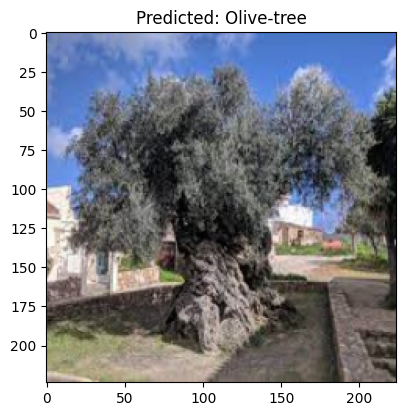

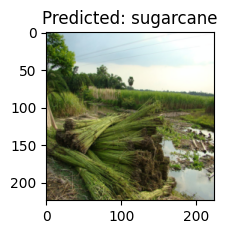

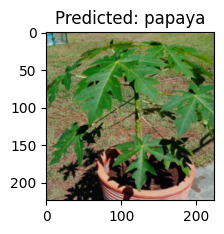

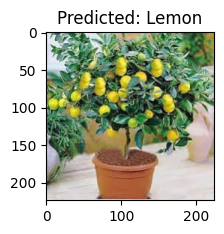

In [57]:
# Функция для отображения изображения и предсказанного класса
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Отображение изображения из тестовой выборки с предсказанным классом
def show_predictions(model, valid_loader, class_names):
    model.eval()
    inputs, labels = next(iter(valid_loader))
    inputs = inputs.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        imshow(inputs.cpu().data[i], title=f'Predicted: {class_names[preds[i]]}')
    plt.show()

# Отображаем предсказания для изображений из тестовой выборки
show_predictions(model_50, valid_loader, dataset.classes)

8. "Разморозь" несоклько слоев базовой модели и вновь обучи ее. Зафиксируй метрику качества для модели. О том, как сделать unfreeze нескольких слоев сразу, а не только последнего, можно почитать тут: [discuss.pytorch.org](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3)

In [58]:
# Размораживаем несколько слоев базовой модели и вновь обучаем ее
for param in list(model_50.parameters())[-10:]:  # Размораживаем последние 10 параметров (примерно два последних блока)
    param.requires_grad = True

optimizer_fine_tune = torch.optim.Adam(filter(lambda p: p.requires_grad, model_50.parameters()), lr=0.0001)

# Обучение модели с размороженными слоями
for epoch in range(num_epochs):
  train_loss_ft = train(model_50, train_loader, criterion, optimizer_fine_tune)
  val_loss_ft, val_acc_ft = evaluate(model_50, valid_loader, criterion)
  print(f'[Fine-tuning] Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_ft:.4f}, Val Loss: {val_loss_ft:.4f}, Val Acc: {val_acc_ft:.4f}')

[Fine-tuning] Epoch 1/15, Train Loss: 0.1839, Val Loss: 0.9730, Val Acc: 0.6988
[Fine-tuning] Epoch 2/15, Train Loss: 0.0925, Val Loss: 0.9031, Val Acc: 0.7470
[Fine-tuning] Epoch 3/15, Train Loss: 0.0566, Val Loss: 0.8796, Val Acc: 0.7410
[Fine-tuning] Epoch 4/15, Train Loss: 0.0382, Val Loss: 0.8569, Val Acc: 0.7530
[Fine-tuning] Epoch 5/15, Train Loss: 0.0326, Val Loss: 0.8674, Val Acc: 0.7410
[Fine-tuning] Epoch 6/15, Train Loss: 0.0270, Val Loss: 0.8661, Val Acc: 0.7470
[Fine-tuning] Epoch 7/15, Train Loss: 0.0167, Val Loss: 0.8618, Val Acc: 0.7349
[Fine-tuning] Epoch 8/15, Train Loss: 0.0157, Val Loss: 0.8472, Val Acc: 0.7410
[Fine-tuning] Epoch 9/15, Train Loss: 0.0137, Val Loss: 0.8301, Val Acc: 0.7410
[Fine-tuning] Epoch 10/15, Train Loss: 0.0142, Val Loss: 0.8321, Val Acc: 0.7530
[Fine-tuning] Epoch 11/15, Train Loss: 0.0101, Val Loss: 0.8229, Val Acc: 0.7530
[Fine-tuning] Epoch 12/15, Train Loss: 0.0085, Val Loss: 0.8264, Val Acc: 0.7771
[Fine-tuning] Epoch 13/15, Train Loss

9. Сравни качество двух моделей: предобученной с замененным выходным слоем и дообученной с несколькими размороженными слоями.

In [4]:
# Сравнение качества моделей
print(f'Initial Model Val Acc: {val_acc:.4f}')
print(f'Fine-tuned Model Val Acc: {val_acc_ft:.4f}')

NameError: name 'val_acc' is not defined

10. Сохрани модель (пример можно посмотреть [тут](../../learning/aux/model_saving.ipynb) или в [документации](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [60]:
# Сохраняем модель
model_path = 'model_50.pth'
torch.save(model_50.state_dict(), model_path)

from google.colab import files

files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# Создайте файл requirements.txt с помощью pip freeze
!pip freeze > requirements.txt

# Скачайте requirements.txt
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>